In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from lightning_modules.diffusion_prior import DiffusionPriorTask
import torch
import matplotlib.pyplot as plt
from data.diffusion import LatentDiffusionDataset
from torch2jax import j2t, t2j
import jax.numpy as jnp
import jax
from jax.scipy.special import rel_entr

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mila/l/leo.gagnon/late

In [69]:
task = DiffusionPriorTask('q0gr8o99')
task.cuda();

Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt
Loaded checkpoing : last.ckpt


In [70]:
dataset = task.train_data.dataset 
dataset: LatentDiffusionDataset

In [71]:
raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = dataset[626].values()

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:608: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


In [72]:
cond_input_ids.shape

torch.Size([1, 50])

In [102]:
xd = 15
cond_mask = torch.BoolTensor([True]*xd + [False]*(50-xd))[None].cuda()

In [103]:
task.diffusion_prior.cfg.sampler = 'ddpm' # ddpm, dpmpp, ddim
task.diffusion_prior.cfg.sampling_timesteps=250

In [104]:
z_t = task.diffusion_prior.sample(512, cond=cond_tokens, cond_mask=cond_mask, cls_free_guidance=1.5)
if task.diffusion_prior.cfg.normalize_latent:
    z_t = task.diffusion_prior.unnormalize_latent(z_t)

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

In [161]:
seq = cond_input_ids[0]

In [162]:
oracle = task.base_task.full_data.bayesian_oracle(jnp.arange(len(task.base_task.full_data)), t2j(seq))

In [163]:
model_out = torch.nn.functional.softmax(task.base_task.model.decoder(seq)[-1,:-1], 0)

In [164]:
model_out = model_out.round(decimals=2).cpu()

In [165]:
oracle_out = j2t(oracle['post_pred'][-1].round(2)).cpu()

In [166]:
decoded_out = torch.nn.functional.softmax(task.base_task.model.decoder.lm_head(z_t[:,-1])[:,:-1],-1)

In [167]:
decoded_out.mean(0).round(decimals=2).cpu()

tensor([0.0000, 0.0400, 0.0000, 0.0200, 0.0000, 0.0300, 0.0200, 0.0000, 0.0200,
        0.3300, 0.0000, 0.0200, 0.0000, 0.0000, 0.0100, 0.0000, 0.0100, 0.0000,
        0.0100, 0.0000, 0.0100, 0.0000, 0.0000, 0.0100, 0.0200, 0.0000, 0.1200,
        0.0000, 0.0400, 0.0300, 0.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0100, 0.0000, 0.0100, 0.0200, 0.0300, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0300, 0.0200, 0.1300])

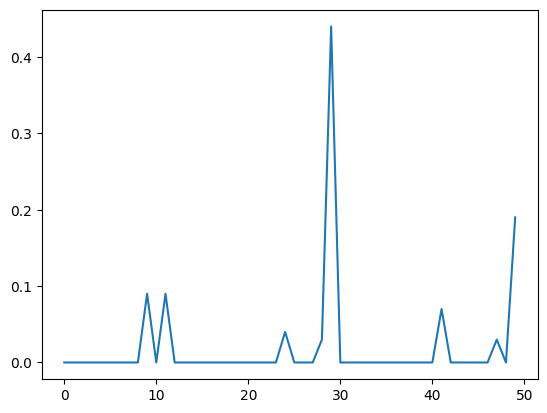

In [173]:
plt.plot(decoded_out[4].round(decimals=2).cpu(), label='Explicit')


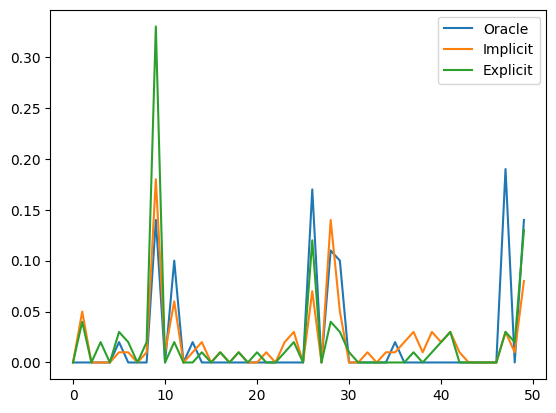

In [168]:
plt.plot(oracle_out, label='Oracle')
plt.plot(model_out, label='Implicit')
plt.plot(decoded_out.mean(0).round(decimals=2).cpu(), label='Explicit')
plt.legend()

In [105]:
decoded_task_latent = [
    torch.Tensor(
        [
            (latent_embds.weight @ sampled_latent.T).argmax()
            for latent_embds in dataset.known_encoder.latent_embedding
        ]
    )
    for sampled_latent in z_t
]
decoded_task_latent = torch.stack(decoded_task_latent, 0)

In [106]:
decoded_task_id = jnp.stack(
    [
        (
            task.base_task.full_data.index_to_latent
            == t2j(decoded_task_latent[i])
        )
        .all(-1)
        .argmax()
        for i in range(len(decoded_task_latent))
    ]
)

In [107]:
empirical_dist = jnp.bincount(decoded_task_id, minlength=len(task.base_task.full_data))
empirical_dist = empirical_dist/empirical_dist.sum()

In [108]:
oracle_dist = task.base_task.full_data.bayesian_oracle(
    jnp.arange(len(task.base_task.full_data)),
    t2j(cond_input_ids[0]),
)['log_alpha_post']

In [114]:
task.base_task.full_data.index_to_latent[empirical_dist.argsort()[-5:]]

Array([[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 2],
       [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2]], dtype=int16)

In [110]:
for id in empirical_dist.nonzero()[0]:
    print(f'HMM {task.base_task.full_data.index_to_latent[id]}, #{id}  : {empirical_dist[id]}')

HMM [0 0 0 0 0 0 1 0 0 0 0 2], #50  : 0.017578125
HMM [0 0 0 0 0 0 1 1 0 0 0 2], #74  : 0.001953125
HMM [0 0 0 0 0 1 0 0 0 0 0 1], #97  : 0.001953125
HMM [0 0 0 0 0 1 0 0 0 0 0 2], #98  : 0.001953125
HMM [0 0 0 0 1 0 0 0 0 0 0 2], #194  : 0.001953125
HMM [0 0 0 0 1 0 1 0 0 0 0 0], #240  : 0.001953125
HMM [0 0 0 0 1 0 1 0 0 0 0 1], #241  : 0.009765625
HMM [0 0 0 0 1 0 1 0 0 0 0 2], #242  : 0.27734375
HMM [0 0 0 0 1 0 1 0 0 0 1 2], #245  : 0.001953125
HMM [0 0 0 0 1 0 1 0 0 1 0 2], #248  : 0.0234375
HMM [0 0 0 0 1 0 1 0 1 0 0 2], #254  : 0.005859375
HMM [0 0 0 0 1 0 1 0 1 1 0 2], #260  : 0.001953125
HMM [0 0 0 0 1 0 1 1 0 0 0 0], #264  : 0.001953125
HMM [0 0 0 0 1 0 1 1 0 0 0 2], #266  : 0.01953125
HMM [0 0 0 0 1 0 1 1 0 1 0 2], #272  : 0.001953125
HMM [0 0 0 0 1 1 0 0 0 0 0 2], #290  : 0.001953125
HMM [0 0 0 0 1 1 0 0 1 1 0 2], #308  : 0.001953125
HMM [0 0 0 0 1 1 0 1 0 1 0 2], #320  : 0.001953125
HMM [0 0 0 0 1 1 1 0 0 0 0 2], #338  : 0.0078125
HMM [0 0 0 1 0 0 0 0 0 0 0 2], #386  : 0.

In [111]:
oracle_ = jnp.exp(oracle_dist[cond_mask.int().argmin().item()+1]).round(2).to_device(jax.devices('cpu')[0])
for id in oracle_.nonzero()[0]:
    print(f'HMM #{id}, {task.base_task.full_data.index_to_latent[id]} : {oracle_[id]}')

HMM #434, [0 0 0 1 0 0 1 0 0 0 0 2] : 0.12999999523162842
HMM #626, [0 0 0 1 1 0 1 0 0 0 0 2] : 0.8700000047683716


In [112]:
empirical_dist_ = empirical_dist + 1e-8
empirical_dist_ = empirical_dist_/empirical_dist_.sum()
rel_entr(oracle_, empirical_dist_).sum()

Array(1.1414005, dtype=float32)

In [113]:
oracle__ = oracle_ + 1e-8
oracle__ = oracle__/oracle__.sum()
rel_entr(empirical_dist, oracle__).sum()

Array(9.887039, dtype=float32)

In [231]:
emb = nn.ModuleList(
    [
        nn.Embedding(
            n,
            512,
        )
        for n in [5,2,2,3]
    ]
)

In [233]:
directions = orthogonal_(torch.zeros((512,512)))

i = 0
for e in emb:
    weight_ = torch.zeros_like(e.weight)
    for j in range(e.weight.shape[0]):
        weight_[j] = directions[i]
        i += 1
    e.weight = nn.Parameter(weight_)

In [234]:
torch.dot(emb[0].weight[0],emb[0].weight[2])

tensor(-3.0734e-08, grad_fn=<DotBackward0>)

In [217]:
emb[0].weight.shape

torch.Size([5, 512])

In [210]:
torch.dot(a[:,0], a[:,5])

tensor(-8.3819e-09)

In [88]:
true = torch.Tensor(
    [
        (latent_embds.weight @ latent[0].T).argmax()
        for latent_embds in task.base_task.model.encoder.latent_embedding
    ]
)

In [86]:
print(f'Accuracy : {torch.mean(torch.sum(preds == true[None],-1)/len(true))}')

Accuracy : 0.6158332824707031


In [95]:
(torch.sum(preds == true[None],0)/100).mean(0)

tensor(0.6158)

In [93]:
len(preds)

100